컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
import numpy as np 
from scipy import stats 

# 플롯의 모든 텍스트에 대해 Times New Roman 폰트 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.unicode_minus'] = False  # Times New Roman 사용 시 마이너스 부호가 올바르게 표시되도록 설정

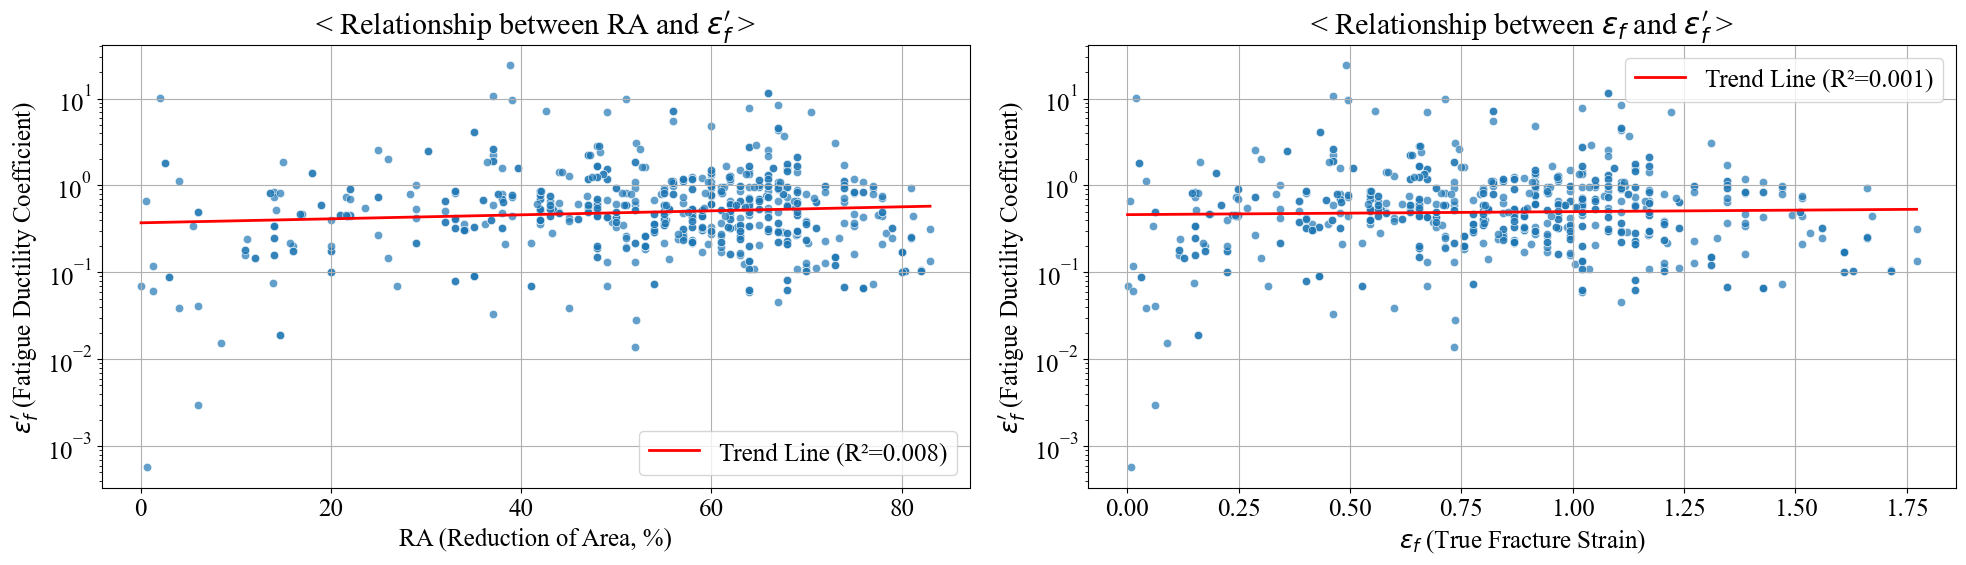

In [3]:
# Excel 파일 읽기
try:
    df_orig = pd.read_excel("TrainSet0507_NoDuplicates.xlsx")
except FileNotFoundError:
    print("Error: 'TrainSet0507_NoDuplicates.xlsx' file not found. Please check the file path.")
    df_orig = pd.DataFrame() # 빈 데이터프레임 생성

if not df_orig.empty:
    # RA와 ef 열이 있는지 확인
    if 'RA' in df_orig.columns and 'ef' in df_orig.columns:
        df = df_orig.copy() # 원본 데이터프레임 복사

        # 데이터 클리닝 및 변환
        # 'RA' 열 처리
        df['RA'] = df['RA'].astype(str).str.replace(',', '.', regex=False)
        df['RA'] = pd.to_numeric(df['RA'], errors='coerce')

        # 'ef' 열 처리
        df['ef'] = df['ef'].astype(str).str.replace(',', '.', regex=False)
        df['ef'] = pd.to_numeric(df['ef'], errors='coerce')

        # 숫자 변환 과정에서 NaN이 된 행들을 제거
        df.dropna(subset=['RA', 'ef'], inplace=True)

        # 1x2 구조로 서브플롯 생성
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # 첫 번째 그래프 (왼쪽): RA vs ef
        # ef > 0 이어야 log(ef)가 가능하므로 필터링
        df_plot1 = df[df['ef'] > 0].copy()
        
        if not df_plot1.empty:
            ra_data1 = df_plot1['RA'].values 
            ef_data1 = df_plot1['ef'].values   
            
            ax1.scatter(ra_data1, ef_data1, alpha=0.7, edgecolors='w', linewidth=0.5)
            
            # 로그 변환된 ef 데이터 준비 (ef_data1은 이미 양수임)
            log_ef_data1 = np.log10(ef_data1)
            
            # linregress를 위한 유효한 데이터 필터링 (NaN, inf 제거)
            valid_indices1 = np.isfinite(ra_data1) & np.isfinite(log_ef_data1)
            ra_clean1 = ra_data1[valid_indices1]
            log_ef_clean1 = log_ef_data1[valid_indices1]

            if len(ra_clean1) >= 2: # 선형 회귀를 위해 최소 2개의 데이터 포인트 필요
                slope, intercept, r_value, p_value, std_err = stats.linregress(ra_clean1, log_ef_clean1)
                
                if np.isfinite(slope) and np.isfinite(intercept) and np.isfinite(r_value):
                    # x_line의 범위를 필터링된 데이터의 min/max로 설정
                    x_line = np.linspace(np.min(ra_clean1), np.max(ra_clean1), 100)
                    y_line = 10**(slope * x_line + intercept)
                    ax1.plot(x_line, y_line, 'r-', linewidth=2, label=f'Trend Line (R²={r_value**2:.3f})')
                else:
                    ax1.plot([], [], 'r-', linewidth=2, label='Trend Line (Calculation Failed)')
            else:
                ax1.plot([], [], 'r-', linewidth=2, label='Trend Line (Insufficient Data)')
            ax1.legend()
        else: # df_plot1이 비어있는 경우 (ef > 0 인 데이터가 없음)
            ax1.text(0.5, 0.5, "Plot 1: No valid data (ef > 0)", ha='center', va='center', transform=ax1.transAxes)
            ax1.plot([], [], 'r-', linewidth=2, label='Trend Line (No Data)') # 범례 항목 유지
            ax1.legend()
        
        ax1.set_xlabel("RA (Reduction of Area, %)")
        ax1.set_ylabel(r"$\varepsilon^{\prime}_f$ (Fatigue Ductility Coefficient)")
        ax1.set_title(r"< Relationship between RA and $\varepsilon^{\prime}_f$ >")
        ax1.set_yscale('log')
        ax1.grid(True)
            
        # 두 번째 그래프 (오른쪽): ln(1/(1-RA/100)) vs ef
        # ef > 0 이고, 0 < RA < 100 이어야 계산 가능하므로 필터링
        df_plot2 = df[(df['ef'] > 0) & (df['RA'] > 0) & (df['RA'] < 100)].copy()
        
        if not df_plot2.empty:
            ra_data2_for_ln = df_plot2['RA'].values 
            ef_data2_for_scatter = df_plot2['ef'].values    

            # ln(1/(1-RA/100)) 계산 (ra_data2_for_ln는 (0,100) 범위이므로 안전)
            ln_ra_data2 = np.log(1 / (1 - ra_data2_for_ln / 100))
            # 로그 변환된 ef 데이터 (ef_data2_for_scatter는 이미 양수)
            log_ef_data2_for_linreg = np.log10(ef_data2_for_scatter)

            # 산점도 데이터 필터링 (계산된 ln_ra_data2가 유효한지 확인)
            valid_scatter_indices = np.isfinite(ln_ra_data2) & np.isfinite(ef_data2_for_scatter)
            
            if np.any(valid_scatter_indices): # 유효한 산점도 데이터가 하나라도 있으면 그림
                ax2.scatter(ln_ra_data2[valid_scatter_indices], ef_data2_for_scatter[valid_scatter_indices], alpha=0.7, edgecolors='w', linewidth=0.5)
            
                # linregress를 위한 유효한 데이터 필터링 (NaN, inf 제거)
                valid_linreg_indices = np.isfinite(ln_ra_data2) & np.isfinite(log_ef_data2_for_linreg)
                ln_ra_clean2 = ln_ra_data2[valid_linreg_indices]
                log_ef_clean2 = log_ef_data2_for_linreg[valid_linreg_indices]

                if len(ln_ra_clean2) >= 2: # 선형 회귀를 위해 최소 2개의 데이터 포인트 필요
                    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(ln_ra_clean2, log_ef_clean2)
                    if np.isfinite(slope2) and np.isfinite(intercept2) and np.isfinite(r_value2):
                        x_line2 = np.linspace(np.min(ln_ra_clean2), np.max(ln_ra_clean2), 100)
                        y_line2 = 10**(slope2 * x_line2 + intercept2)
                        ax2.plot(x_line2, y_line2, 'r-', linewidth=2, label=f'Trend Line (R²={r_value2**2:.3f})')
                    else:
                        ax2.plot([], [], 'r-', linewidth=2, label='Trend Line (Calculation Failed)')
                else:
                    ax2.plot([], [], 'r-', linewidth=2, label='Trend Line (Insufficient Data)')
            else: # 유효한 산점도 데이터가 없는 경우
                ax2.text(0.5, 0.5, "Plot 2: No valid scatter data after transformation", ha='center', va='center', transform=ax2.transAxes)
                ax2.plot([], [], 'r-', linewidth=2, label='Trend Line (No Data)') # 범례 항목 유지
            ax2.legend()
        else: # df_plot2가 비어있는 경우 (0<RA<100, ef>0 인 데이터가 없음)
            ax2.text(0.5, 0.5, "Plot 2: No valid data (0<RA<100, ef>0)", ha='center', va='center', transform=ax2.transAxes)
            ax2.plot([], [], 'r-', linewidth=2, label='Trend Line (No Data)') # 범례 항목 유지
            ax2.legend()
            
        ax2.set_xlabel(r"$\varepsilon_f$ (True Fracture Strain)")
        ax2.set_ylabel(r"$\varepsilon^{\prime}_f$ (Fatigue Ductility Coefficient)")
        ax2.set_title(r"< Relationship between $\varepsilon_f$ and $\varepsilon^{\prime}_f$ >")
        ax2.set_yscale('log')
        ax2.grid(True)
            
        plt.tight_layout()
        plt.show()

        # 모든 플롯에 대한 데이터가 없는 경우 메시지 출력
        if df_plot1.empty and df_plot2.empty and not df.empty : # df는 있으나 필터링 후 plot 데이터가 없는 경우
             print("No valid RA or ef data available after filtering for plotting.")
        elif df.empty and not df_orig.empty: # 초기 NaN 제거 후 df가 비어버린 경우
             print("No data remains after initial NaN removal from RA or ef columns.")

    else: # RA 또는 ef 컬럼이 원본 파일에 없는 경우
        missing_cols = []
        if 'RA' not in df_orig.columns:
            missing_cols.append('RA')
        if 'ef' not in df_orig.columns:
            missing_cols.append('ef')
        print(f"Error: Column(s) '{', '.join(missing_cols)}' not found in the file. Please check the column names.")


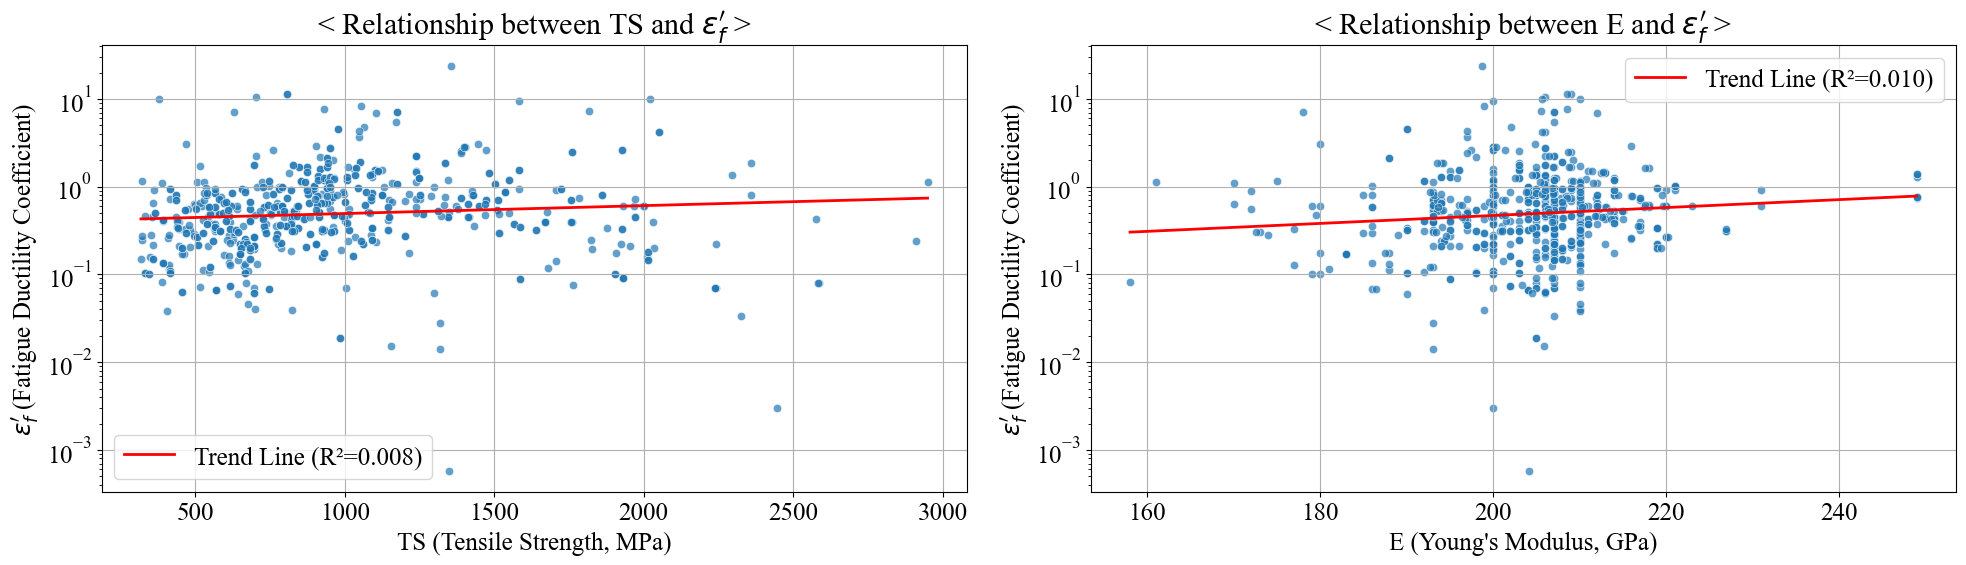

In [7]:
# 추가 그래프 생성을 위한 코드
if not df_orig.empty:
    # TS와 E 열이 있는지 확인
    required_cols = ['RA', 'ef', 'TS', 'E']
    missing_cols = [col for col in required_cols if col not in df_orig.columns]
    
    if not missing_cols:
        # 데이터 준비
        df_add = df_orig.copy()
        
        # 데이터 클리닝 및 변환
        for col in required_cols:
            df_add[col] = df_add[col].astype(str).str.replace(',', '.', regex=False)
            df_add[col] = pd.to_numeric(df_add[col], errors='coerce')
        
        # 숫자 변환 과정에서 NaN이 된 행들을 제거
        df_add.dropna(subset=required_cols, inplace=True)
        
        # 1x2 구조로 서브플롯 생성
        fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6))
        
        # 세 번째 그래프 (왼쪽): TS vs ef
        # ef > 0 이어야 log(ef)가 가능하므로 필터링
        df_plot3 = df_add[df_add['ef'] > 0].copy()
        
        if not df_plot3.empty:
            ts_data = df_plot3['TS'].values 
            ef_data3 = df_plot3['ef'].values   
            
            ax3.scatter(ts_data, ef_data3, alpha=0.7, edgecolors='w', linewidth=0.5)
            
            # 로그 변환된 ef 데이터 준비
            log_ef_data3 = np.log10(ef_data3)
            
            # linregress를 위한 유효한 데이터 필터링 (NaN, inf 제거)
            valid_indices3 = np.isfinite(ts_data) & np.isfinite(log_ef_data3)
            ts_clean = ts_data[valid_indices3]
            log_ef_clean3 = log_ef_data3[valid_indices3]

            if len(ts_clean) >= 2: # 선형 회귀를 위해 최소 2개의 데이터 포인트 필요
                slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(ts_clean, log_ef_clean3)
                
                if np.isfinite(slope3) and np.isfinite(intercept3) and np.isfinite(r_value3):
                    # x_line의 범위를 필터링된 데이터의 min/max로 설정
                    x_line3 = np.linspace(np.min(ts_clean), np.max(ts_clean), 100)
                    y_line3 = 10**(slope3 * x_line3 + intercept3)
                    ax3.plot(x_line3, y_line3, 'r-', linewidth=2, label=f'Trend Line (R²={r_value3**2:.3f})')
                else:
                    ax3.plot([], [], 'r-', linewidth=2, label='Trend Line (Calculation Failed)')
            else:
                ax3.plot([], [], 'r-', linewidth=2, label='Trend Line (Insufficient Data)')
            ax3.legend()
        else: # df_plot3이 비어있는 경우
            ax3.text(0.5, 0.5, "Plot 3: No valid data (ef > 0)", ha='center', va='center', transform=ax3.transAxes)
            ax3.plot([], [], 'r-', linewidth=2, label='Trend Line (No Data)') # 범례 항목 유지
            ax3.legend()
        
        ax3.set_xlabel("TS (Tensile Strength, MPa)")
        ax3.set_ylabel(r"$\varepsilon^{\prime}_f$ (Fatigue Ductility Coefficient)")
        ax3.set_title(r"< Relationship between TS and $\varepsilon^{\prime}_f$ >")
        ax3.set_yscale('log')
        ax3.grid(True)
            
        # 네 번째 그래프 (오른쪽): E vs ef
        # ef > 0 이어야 log(ef)가 가능하므로 필터링
        df_plot4 = df_add[df_add['ef'] > 0].copy()
        
        if not df_plot4.empty:
            e_data = df_plot4['E'].values 
            ef_data4 = df_plot4['ef'].values   
            
            ax4.scatter(e_data, ef_data4, alpha=0.7, edgecolors='w', linewidth=0.5)
            
            # 로그 변환된 ef 데이터 준비
            log_ef_data4 = np.log10(ef_data4)
            
            # linregress를 위한 유효한 데이터 필터링 (NaN, inf 제거)
            valid_indices4 = np.isfinite(e_data) & np.isfinite(log_ef_data4)
            e_clean = e_data[valid_indices4]
            log_ef_clean4 = log_ef_data4[valid_indices4]

            if len(e_clean) >= 2: # 선형 회귀를 위해 최소 2개의 데이터 포인트 필요
                slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(e_clean, log_ef_clean4)
                
                if np.isfinite(slope4) and np.isfinite(intercept4) and np.isfinite(r_value4):
                    # x_line의 범위를 필터링된 데이터의 min/max로 설정
                    x_line4 = np.linspace(np.min(e_clean), np.max(e_clean), 100)
                    y_line4 = 10**(slope4 * x_line4 + intercept4)
                    ax4.plot(x_line4, y_line4, 'r-', linewidth=2, label=f'Trend Line (R²={r_value4**2:.3f})')
                else:
                    ax4.plot([], [], 'r-', linewidth=2, label='Trend Line (Calculation Failed)')
            else:
                ax4.plot([], [], 'r-', linewidth=2, label='Trend Line (Insufficient Data)')
            ax4.legend()
        else: # df_plot4가 비어있는 경우
            ax4.text(0.5, 0.5, "Plot 4: No valid data (ef > 0)", ha='center', va='center', transform=ax4.transAxes)
            ax4.plot([], [], 'r-', linewidth=2, label='Trend Line (No Data)') # 범례 항목 유지
            ax4.legend()
        
        ax4.set_xlabel("E (Young's Modulus, GPa)")
        ax4.set_ylabel(r"$\varepsilon^{\prime}_f$ (Fatigue Ductility Coefficient)")
        ax4.set_title(r"< Relationship between E and $\varepsilon^{\prime}_f$ >")
        ax4.set_yscale('log')
        ax4.grid(True)
            
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Column(s) '{', '.join(missing_cols)}' not found in the file. Please check the column names.")
